<a href="https://colab.research.google.com/github/srinath2022/physics-based-DL/blob/master/simpleExperiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiments on Toy Example

We will start off by considering a toy example of tossing a coin and eventually add air resistance etc. Let us begin by writing down the velocity and displacement equations of a point mass object thrown vertically above the ground with an initial velocity $u_0$.   

Under the effect of gravity, the velocity of the object at any time instant from start($t=0$) is given by   

$ v_t = u_0 + gt $   

where $g$ represents acceleration due to gravity $\sim 10 \frac{m}{s^2}$ 

Also, the displacement covered by the point mass is given by

$ s_t = u_0t + \frac{1}{2}gt^2 $


## The Simulation

We first show a simulation of this using pure physics equations. For simplicity let us target the velocity first, as it is linear with time.

In [1]:
# Import necessary modules
import matplotlib.pyplot as plt

In [2]:
# Acceleration due to gravity
g = -10 # m/s^2

In [3]:
# Velocity of the particle at time step T. Initial velocity of the particle is u.
def velocity_t(u, t):
  return u + g*t

In [4]:
# Displacement by the particle
def displacement_t(u, t):
  return u*t+(1/2)*g*t*t

In [5]:
def simulate_flight(u_initial):
  T =  -2*u_initial/(g) # time of flight
  t = 0
  times = []
  velocities = []
  displacements = []
  # calculate velocity at evert time step (of one second interval)
  while t <= T:
    v_t = velocity_t(u_initial, t)
    s_t = displacement_t(u_initial, t)
    times.append(t)
    velocities.append(v_t)
    displacements.append(s_t)
    t = t+(1/5)

  return times, velocities, displacements

In [6]:
# Plot the simulation
def plot_simulation(times, velocities, displacements):
  plt.plot(times, velocities)
  plt.plot(times, displacements)
  plt.ylabel('velocity')
  plt.xlabel('time')
  plt.show()

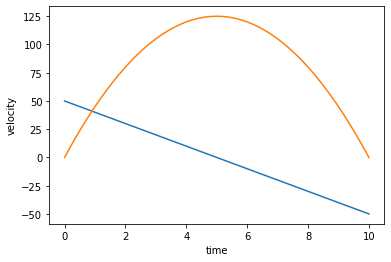

In [7]:
# Testing the simulation
times, velocities, displacements = simulate_flight(50)
plot_simulation(times, velocities, displacements)

## The Data
Now that we have a physics simulation, let us run few simulations and collect the data. i,e we input few random initial velocities, times and get the corresponding velocities during the flight.

For this specific task, let us keep the initial velocities between $0$ to $100$ and time step range betwen $0$ to time of flight $T.$ 

$$u_0 \in (0, 100)$$

The collected data would look like this, $X, Y$ where
$X = (u, t), Y = (v)$   
$u, t$ represent initial velocity and time step, where as $v$ represents corresponding velocity.

In [8]:
import numpy as np

In [9]:
# Min and Max of initial velocity (in m/s)
U0_MIN = 0
U0_MAX = 100

def create_data(N_DATA_SAMPLES, D_TYPE, U0_MIN=U0_MIN, U0_MAX=U0_MAX):
  if D_TYPE not in ['VELOCITY', 'DISPLACEMENT', 'VELOCITY_DISPLACEMENT']:
    return
  data = []
  for i in range(N_DATA_SAMPLES):
    u0 = U0_MIN + np.random.rand(1)*(U0_MAX - U0_MIN)
    T   = (-2*u0)/g # time of flight
    t   = np.random.rand(1)*T
    v_t = velocity_t(u0, t)
    s_t = displacement_t(u0, t)

    # create a data point
    Y = None
    if D_TYPE=='VELOCITY':
      Y = np.array([v_t])
    elif D_TYPE=='DISPLACEMENT':
      Y = np.array([s_t])
    elif D_TYPE=='VELOCITY_DISPLACEMENT':
      Y = np.array([v_t, s_t])
    else:
      return

    datapoint = (np.array([u0, t]), Y)
    data.append(datapoint)

  print("Dataset created!!")
  print("Dataset size", len(data))
  return data

## Only Deep Learing based approach

We have collectd some data, Let us use a simple neural network to train upon that data to predict the velocity $v_t$ at a time $t$, given an initial veclocity $u_0$.

We will be experimenting with various models, train them and try the inference.

In [10]:
# Necessary modules
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else  "cpu")
print(device)

cuda:0


In [11]:
def compare_plot(times, actual, predicted, D_TYPE):
  plt.figure()
  plt.plot(times, actual, 'g')
  plt.plot(times, predicted, 'b')
  plt.ylabel(D_TYPE)
  plt.xlabel('time')
  plt.show()

In [12]:
# Plotting the train loss curve
def loss_plot(epochs, losses):
  plt.figure()
  plt.plot(epochs, losses, 'r')
  plt.ylabel("Loss")
  plt.xlabel('Epoch')
  plt.show()

### Dataset
Let us define the appropriate dataset.

In [13]:
# Dataset
class PhysicsData(Dataset):
  def __init__(self, data):
    self.data = data
  def __len__(self):
    return len(self.data)
  def __getitem__(self, index):
    return self.data[index]

### Inference
Let us first create and keep the inference part ready, so that we could infer and check the infered simulation on any trained network. This will make our life easier to test with various models we might try out until a good fitting one is found.

This is to infer the output for a single input, say at time $t$, for given initial velocity $u_0$

In [14]:
# Infer the output for a single input (at time t, given initial velocity) on the trained network.
# Assuming model is already transferred to the device.
def single_inference(D_TYPE, model, u0, t):
  input   = torch.tensor([[u0, t]])
  input   = input.unsqueeze(0)
  input   = input.to(device)
  output  = model(input.float())
  output  = output.cpu().data.numpy()

  if D_TYPE=='VELOCITY':
    return output[0][0][0], 0
  elif D_TYPE=='DISPLACEMENT':
    return 0, output[0][0][0]
  elif D_TYPE=='VELOCITY_DISPLACEMENT':
    return output[0][0][0], output[0][0][1]
  else:
    return

Now, let us use the single inference to infer the whole simulation, given the initial velocity $u_0$

In [15]:
def simulation_inference(D_TYPE, model, u0):
  model = model.to(device)
  T = (-2*u0)/g # time of flight
  t = 0
  times = []
  velocities = []
  displacements = []
  # calculate velocity at evert time step (of one second interval)
  while t <= T:
    v_t = None
    s_t = None
    v_t, s_t = single_inference(D_TYPE, model, u0, t)
    times.append(t)
    velocities.append(v_t)
    displacements.append(s_t)
    t = t+(1/5)

  return times, velocities, displacements

### Training
We write the appropriate training module to train any generic model with specified parameters

In [16]:
# Training
def train(model, train_dataloader, optimizer, criterion, epochs, verbose=False):
  model = model.to(device)
  model.train()

  all_epochs = []
  all_losses = []

  epoch_loss = 0.0
  for epoch in range(epochs):
    epoch_loss = 0.0
    for i, batch in enumerate(train_dataloader):
      X, Y  = batch[0], batch[1]
      X     = torch.transpose(X, 1, 2)
      Y     = torch.transpose(Y, 1, 2)
      X     = X.to(device)
      Y     = Y.to(device)
      Y_predicted = model(X.float())

      optimizer.zero_grad()
      loss = criterion(Y_predicted, Y.float(), X.float())
      epoch_loss = epoch_loss+loss.item()
      loss.backward()
      optimizer.step()

    if verbose:
      print(f"epoch : {epoch+1}, loss : {epoch_loss/len(train_dataloader):.5f}")
    else:
      if epoch%10 == 0:
        print(f"epoch : {epoch}, loss : {epoch_loss/len(train_dataloader):.5f}")

    all_epochs.append(epoch+1)
    all_losses.append(epoch_loss/len(train_dataloader))
  
  print("Done Training!")
  print(f"epoch : {epochs}, loss : {epoch_loss/len(train_dataloader):.5f}")
  return model, all_losses, all_epochs


In [17]:
# Testing
def test(model, test_dataloader, criterion):
  model = model.to(device)
  model.eval()

  total_loss = 0.0
  with torch.no_grad():
    for i, batch in enumerate(test_dataloader):
      X, Y  = batch[0], batch[1]
      X     = torch.transpose(X, 1, 2)
      Y     = torch.transpose(Y, 1, 2)
      X     = X.to(device)
      Y     = Y.to(device)
      Y_predicted = model(X.float())

      loss = criterion(Y_predicted, Y.float(), X.float())
      total_loss = total_loss+loss.item()

  avarage_loss = total_loss/len(test_dataloader)
  print(f"Average loss : {avarage_loss:.5f}")
  return avarage_loss

### Models
Define various models.

In [18]:
# A Simple model for predicting only Velocity
class VelocityNewtonNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.nn1 = nn.Linear(in_features=2, out_features=5)
    self.nn2 = nn.Linear(in_features=5, out_features=5)
    self.nn3 = nn.Linear(in_features=5, out_features=1)
    self.relu = nn.ReLU()
    
  def forward(self, x):
    x = self.nn1(x)
    x = self.relu(x)
    x = self.nn2(x)
    x = self.relu(x)
    x = self.nn3(x)
    return x

In [19]:
# Simple model for predicting Displacement
# Similar to the Velocity Model, but has more neurons.
class DisplacementNewtonNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.nn1 = nn.Linear(in_features=2, out_features=16)
    self.nn2 = nn.Linear(in_features=16, out_features=16)
    self.nn3 = nn.Linear(in_features=16, out_features=1)
    self.relu = nn.ReLU()
    
  def forward(self, x):
    x = self.nn1(x)
    x = self.relu(x)
    x = self.nn2(x)
    x = self.relu(x)
    x = self.nn3(x)
    return x

In [20]:
# Simple model for predicting both Velocity and Displacement
class NewtonNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.nn1 = nn.Linear(in_features=2, out_features=16)
    self.nn2 = nn.Linear(in_features=16, out_features=4)
    self.nn3 = nn.Linear(in_features=4, out_features=2)
    self.tanh = nn.Tanh()
    
  def forward(self, x):
    x = self.nn1(x)
    x = self.tanh(x)
    x = self.nn2(x)
    x = self.tanh(x)
    x = self.nn3(x)
    return x

### Experiments
We run experiments on various models, keep track of hyperparameters, run inference and try to find the best model for our goal.

Let us define custom Loss class to handle various losses we might design later

In [21]:
# Define custom loss
class CustomMSELoss(nn.Module):
  def __init__(self):
    super(CustomMSELoss, self).__init__()
    self.mseLoss = nn.MSELoss()

  def forward(self, Y_predicted, Y_actual, X):
    loss = self.mseLoss(Y_predicted, Y_actual)
    return loss

#### Predicting only Velocity
Let us use the simplest model, VelocityNewtonNet to predict velocity.
We will create a dataset of 10000 entries for this.

In [22]:
N_DATA_SAMPLES = 10000
simulation_data_velocity = create_data(N_DATA_SAMPLES, 'VELOCITY')
train_dataset_velocity_10000 = PhysicsData(simulation_data_velocity[:int(N_DATA_SAMPLES*0.8)])
test_dataset_velocity_10000 = PhysicsData(simulation_data_velocity[int(N_DATA_SAMPLES*0.8):])

Dataset created!!
Dataset size 10000


Train the network on the velocity dataset.

In [23]:
BATCH_SIZE          = 8
model_v             = VelocityNewtonNet()
train_dataloader_v  = DataLoader(train_dataset_velocity_10000, batch_size=BATCH_SIZE, shuffle=True)
# optimizer_v         = optim.SGD(model_v.parameters(), lr= 0.000001, momentum=0.9)
optimizer_v         = optim.Adam(model_v.parameters(), lr = 0.005)
criterion           = CustomMSELoss()
epochs              = 30

epoch : 0, loss : 326.85944
epoch : 10, loss : 0.01561
epoch : 20, loss : 0.17811
Done Training!
epoch : 30, loss : 0.08867


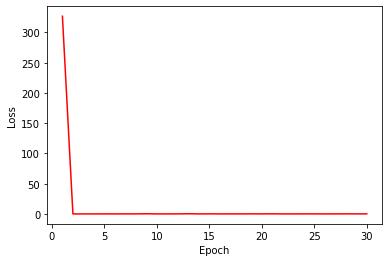

In [24]:
model_v, t_loss, t_epochs = train(model_v, train_dataloader_v, optimizer_v, criterion, epochs, verbose=False)
loss_plot(t_epochs, t_loss)

Calculate the test loss and run few inferences to visualise the prediction.

In [25]:
# Test loss
test_dataloader_v = DataLoader(test_dataset_velocity_10000, batch_size=BATCH_SIZE, shuffle=True)
avg_loss = test(model_v, test_dataloader_v, criterion)

Average loss : 0.00935


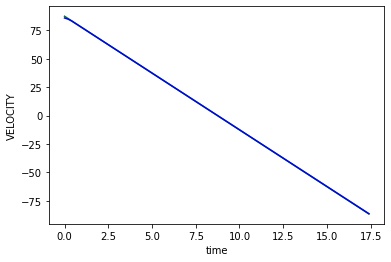

In [26]:
# Run simulation and compare
U_INITIAL = 87.4356
times_p, velocities_p, displacements_p = simulation_inference('VELOCITY', model_v, U_INITIAL)
times, velocities, displacements = simulate_flight(U_INITIAL)
compare_plot(times, velocities, velocities_p, 'VELOCITY')

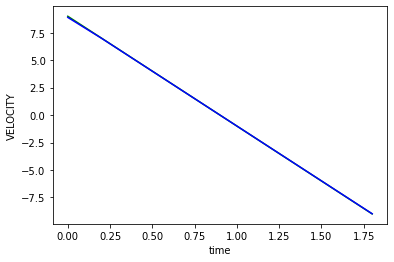

In [27]:
# Run simulation and compare, a case where it doesn't match exactly
U_INITIAL = 9
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY', model_v, U_INITIAL)
times, velocities, displacements        = simulate_flight(U_INITIAL)
compare_plot(times, velocities, velocities_p, 'VELOCITY')

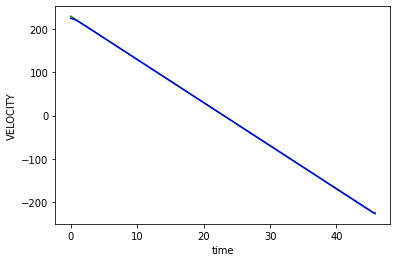

In [28]:
# Run simulation and compare, a case where u0 is out of dataset domain
U_INITIAL = 230
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY', model_v, U_INITIAL)
times, velocities, displacements        = simulate_flight(U_INITIAL)
compare_plot(times, velocities, velocities_p, 'VELOCITY')

#### Predicting only Displacement

In [29]:
# Let us create a similar dataset for displacement task
N_DATA_SAMPLES                    = 10000
simulation_data_displacement      = create_data(N_DATA_SAMPLES, 'DISPLACEMENT')
train_dataset_displacement_10000  = PhysicsData(simulation_data_displacement [:int(N_DATA_SAMPLES*0.8)])
test_dataset_displacement_10000   = PhysicsData(simulation_data_displacement [int(N_DATA_SAMPLES*0.8):])

Dataset created!!
Dataset size 10000


In [30]:
BATCH_SIZE          = 32
model_s             = DisplacementNewtonNet()
train_dataloader_s  = DataLoader(train_dataset_displacement_10000, batch_size=BATCH_SIZE, shuffle=True)
# optimizer_s         = optim.SGD(model_s.parameters(), lr= 0.000001, momentum=0.9)
optimizer_s         = optim.Adam(model_s.parameters(), lr = 0.005)
criterion           = CustomMSELoss()
epochs              = 120

epoch : 0, loss : 8162.80952
epoch : 10, loss : 63.75329
epoch : 20, loss : 42.24356
epoch : 30, loss : 37.44507
epoch : 40, loss : 37.27937
epoch : 50, loss : 40.31626
epoch : 60, loss : 26.76985
epoch : 70, loss : 35.68218
epoch : 80, loss : 29.79484
epoch : 90, loss : 26.34226
epoch : 100, loss : 30.06333
epoch : 110, loss : 26.04673
Done Training!
epoch : 120, loss : 25.59000


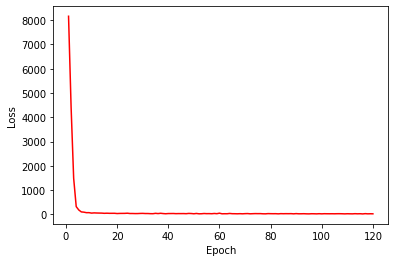

In [31]:
model_s, t_loss, t_epochs = train(model_s, train_dataloader_s, optimizer_s, criterion, epochs, verbose=False)
loss_plot(t_epochs, t_loss)

In [32]:
# Test loss
test_dataloader_s = DataLoader(test_dataset_displacement_10000, batch_size=BATCH_SIZE, shuffle=True)
avg_loss = test(model_s, test_dataloader_s, criterion)

Average loss : 22.61735


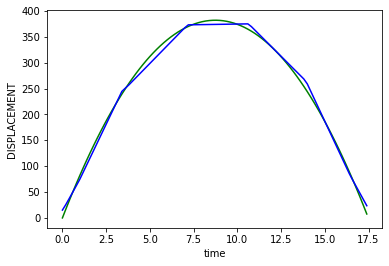

In [33]:
# Run simulation and compare
U_INITIAL = 87.4356
times_p, velocities_p, displacements_p  = simulation_inference('DISPLACEMENT', model_s, U_INITIAL)
times, velocities, displacements        = simulate_flight(U_INITIAL)
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

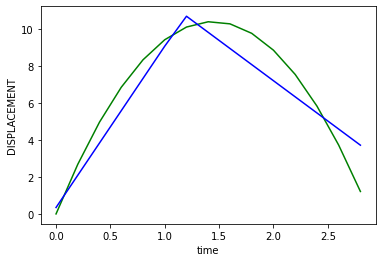

In [34]:
# Run simulation and compare, a case where u0 is small
U_INITIAL = 14.434
times_p, velocities_p, displacements_p  = simulation_inference('DISPLACEMENT', model_s, U_INITIAL)
times, velocities, displacements        = simulate_flight(U_INITIAL)
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

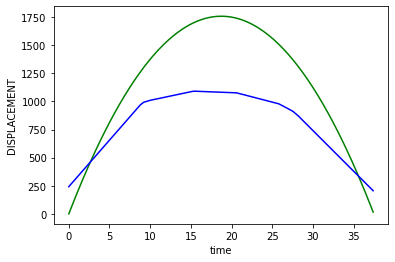

In [35]:
# Run simulation and compare, a case where u0 is not in dataset domain
U_INITIAL = 187.434
times_p, velocities_p, displacements_p  = simulation_inference('DISPLACEMENT', model_s, U_INITIAL)
times, velocities, displacements        = simulate_flight(U_INITIAL)
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

#### Predicting both Velocity and Displacement

In [36]:
# Let us create a similar dataset for velocity, displacement task
N_DATA_SAMPLES                    = 10000
simulation_data_v_s               = create_data(N_DATA_SAMPLES, 'VELOCITY_DISPLACEMENT')
train_dataset_v_s_10000           = PhysicsData(simulation_data_v_s[:int(N_DATA_SAMPLES*0.8)])
test_dataset_v_s_10000            = PhysicsData(simulation_data_v_s[int(N_DATA_SAMPLES*0.8):])

Dataset created!!
Dataset size 10000


In [37]:
BATCH_SIZE            = 32
model_v_s             = NewtonNet()
train_dataloader_v_s  = DataLoader(train_dataset_v_s_10000, batch_size=BATCH_SIZE, shuffle=True)
# optimizer_v_s         = optim.SGD(model_v_s.parameters(), lr=0.000001, momentum=0.9)
optimizer_v_s         = optim.Adam(model_v_s.parameters(), lr = 0.005)
criterion             = CustomMSELoss()
epochs                = 300

epoch : 0, loss : 13822.24905
epoch : 10, loss : 8653.06815
epoch : 20, loss : 5378.67479
epoch : 30, loss : 3243.59603
epoch : 40, loss : 1880.70955
epoch : 50, loss : 1039.88105
epoch : 60, loss : 552.54683
epoch : 70, loss : 295.55351
epoch : 80, loss : 176.99002
epoch : 90, loss : 96.57844
epoch : 100, loss : 66.54121
epoch : 110, loss : 50.17399
epoch : 120, loss : 44.06991
epoch : 130, loss : 33.01359
epoch : 140, loss : 63.11560
epoch : 150, loss : 38.49528
epoch : 160, loss : 30.07233
epoch : 170, loss : 21.95631
epoch : 180, loss : 24.21008
epoch : 190, loss : 30.46672
epoch : 200, loss : 26.90120
epoch : 210, loss : 23.27552
epoch : 220, loss : 15.90749
epoch : 230, loss : 17.98335
epoch : 240, loss : 14.93066
epoch : 250, loss : 21.92199
epoch : 260, loss : 24.02537
epoch : 270, loss : 31.35591
epoch : 280, loss : 19.92082
epoch : 290, loss : 25.65846
Done Training!
epoch : 300, loss : 22.81455


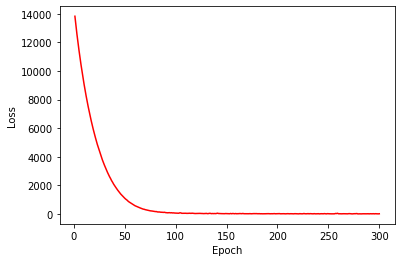

In [38]:
model_v_s, t_loss, t_epochs = train(model_v_s, train_dataloader_v_s, optimizer_v_s, criterion, epochs)
loss_plot(t_epochs, t_loss)

In [39]:
# Test loss
test_dataloader_v_s = DataLoader(test_dataset_v_s_10000, batch_size=BATCH_SIZE, shuffle=True)
avg_loss = test(model_v_s, test_dataloader_v_s, criterion)

Average loss : 9.24421


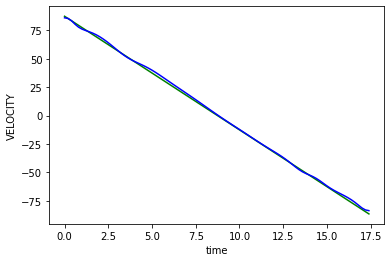

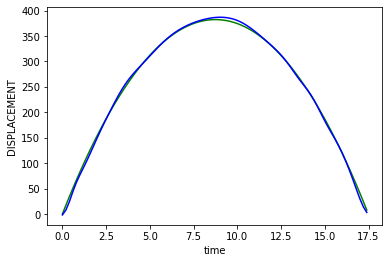

In [40]:
# Run simulation and compare
U_INITIAL = 87.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s, U_INITIAL)
times, velocities, displacements        = simulate_flight(U_INITIAL)
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

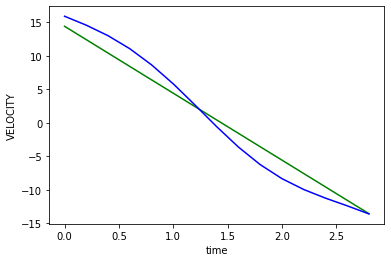

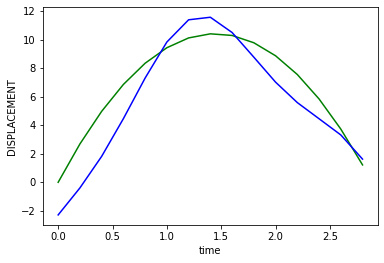

In [41]:
# Run simulation and compare, a case when u0 is small
U_INITIAL = 14.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s, U_INITIAL)
times, velocities, displacements        = simulate_flight(U_INITIAL)
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

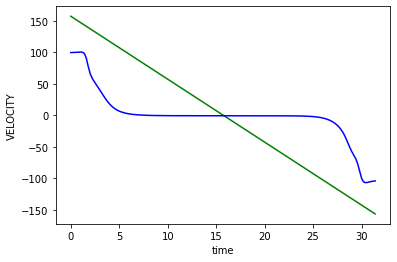

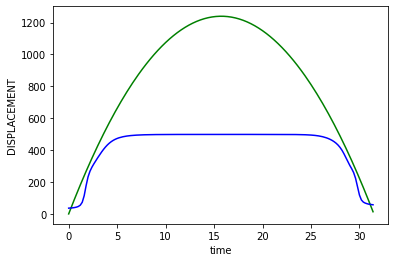

In [42]:
# Run simulation and compare, case where u0 is not part of train set
U_INITIAL = 157.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s, U_INITIAL)
times, velocities, displacements        = simulate_flight(U_INITIAL)
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

## Using Physics Knowledge for training
As we know some properties of the predicted values from physics, like the velocities over time lie on a line, displacements over time lie on a parabola and also $v_t$, $s_t$ have the following relation   

$v_t^2-u_0^2 = 2*g*s_t$

Let us try to leverage this knowledge and see if it improves our model.

In [43]:
# Simple model for predicting both Velocity and Displacement
class PhysicsNewtonNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.nn1 = nn.Linear(in_features=2, out_features=16)
    self.bn1 = nn.BatchNorm1d(16)
    self.nn2 = nn.Linear(in_features=16, out_features=4)
    self.bn2 = nn.BatchNorm1d(4)
    self.nn3 = nn.Linear(in_features=4, out_features=2)
    self.tanh = nn.Tanh()
    self.relu = nn.ReLU()
    
  def forward(self, x):
    x = self.nn1(x)
    x = self.relu(x)
    x = self.nn2(x)
    x = self.relu(x)
    x = self.nn3(x)
    return x

#### Designing a Loss function
We are trying to predict two values namely $v_t$ and $s_t$. From our previous experiments, it is evident that prediction of velocity is fairly accurate even for a minimal network, however prediction of displacement is in accurate and kind of overfit. 

##### 1. Physics based loss
Leveraging the relationship between predicted values $v_t$ and $s_t$, let us try experimenting with the following loss purly based on physics.

$L_{physics} = |v_{predicted}^2-u_{initial}^2-2*g*s_{predicted}|$

In [44]:
# Define new loss
class PhysicsBasedLoss(nn.Module):
  def __init__(self):
    super(PhysicsBasedLoss, self).__init__()

  def forward(self, Y_predicted, Y_actual, X):
    v_predicted = Y_predicted[:, :, 0]
    s_predicted = Y_predicted[:, :, 1]
    u_initial = X[:, :, 0]
    v_square_from_s = torch.add(torch.square(u_initial), 2*g*s_predicted)
    v_square_from_predicted = torch.square(v_predicted)
    difference = torch.subtract(v_square_from_predicted, v_square_from_s)
    absolute_difference = torch.absolute(difference)
    loss = torch.sum(absolute_difference)
    return loss

In [45]:
# We will be using the same datset as for velocity_displacement task.
BATCH_SIZE            = 32
model_v_s_phy         = PhysicsNewtonNet()
train_dataloader_v_s  = DataLoader(train_dataset_v_s_10000, batch_size=BATCH_SIZE, shuffle=True)
# optimizer_v_s_phy     = optim.SGD(model_v_s_phy.parameters(), lr=0.0001, momentum=0.9)
optimizer_v_s_phy     = optim.Adam(model_v_s_phy.parameters(), lr = 0.0005)
criterion             = PhysicsBasedLoss()
epochs                = 200

epoch : 0, loss : 96656.96452
epoch : 10, loss : 313.23299
epoch : 20, loss : 147.61090
epoch : 30, loss : 137.09389
epoch : 40, loss : 169.79906
epoch : 50, loss : 128.70054
epoch : 60, loss : 117.07415
epoch : 70, loss : 140.31452
epoch : 80, loss : 165.58238
epoch : 90, loss : 134.05531
epoch : 100, loss : 151.84270
epoch : 110, loss : 164.55105
epoch : 120, loss : 172.79915
epoch : 130, loss : 99.61577
epoch : 140, loss : 141.64114
epoch : 150, loss : 152.37413
epoch : 160, loss : 137.16883
epoch : 170, loss : 137.62961
epoch : 180, loss : 144.48976
epoch : 190, loss : 108.09570
Done Training!
epoch : 200, loss : 190.58304


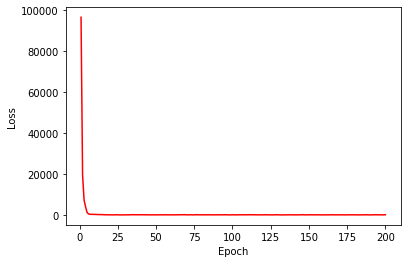

In [46]:
model_v_s_phy, t_loss, t_epochs = train(model_v_s_phy, train_dataloader_v_s, optimizer_v_s_phy, criterion, epochs)
loss_plot(t_epochs, t_loss)

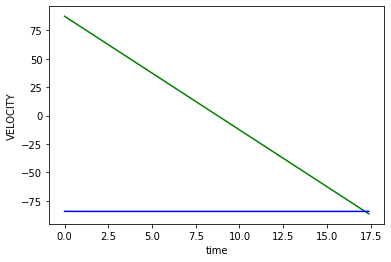

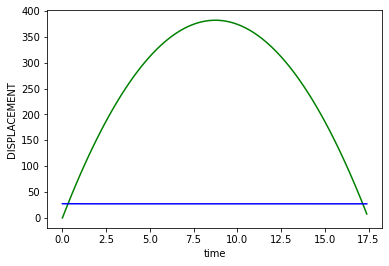

In [47]:
# Run simulation and compare
U_INITIAL = 87.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s_phy, U_INITIAL)
times, velocities, displacements        = simulate_flight(U_INITIAL)
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

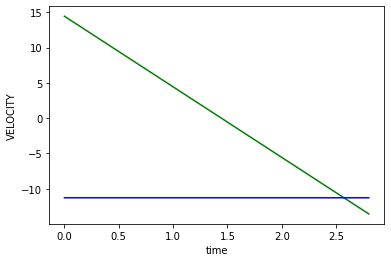

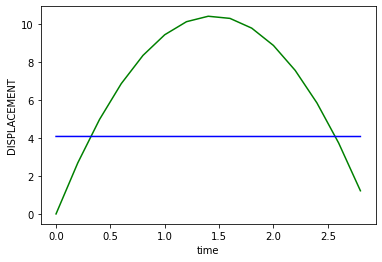

In [48]:
# Run simulation and compare, smaller velocity
U_INITIAL = 14.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s_phy, U_INITIAL)
times, velocities, displacements        = simulate_flight(U_INITIAL)
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

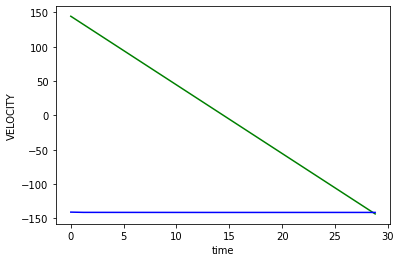

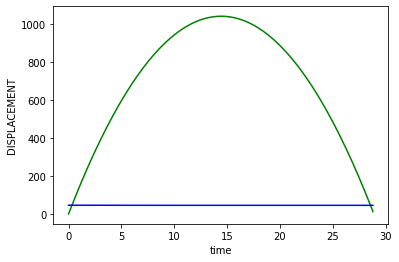

In [49]:
# Run simulation and compare, out of domain velocity
U_INITIAL = 144.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s_phy, U_INITIAL)
times, velocities, displacements        = simulate_flight(U_INITIAL)
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

First of all, the model hasn't converged fully. However, the predictions make sense as we are not using the time input. The model just learns to predict $v_t, s_t$, such that the physics equation holds, but they need not be consistent with the one's we are expecting in a flight. In this case, looks like the model is predictin $s_t=0$, and therefore $v_t\sim u_0$.

##### 2. Velocity + Physics based loss
Let us try the folowing loss where we try to make the velocity closer to actual velocity but provide no ground truth information on displacement, rather we make use of the relation between $v_t$, $s_t$ to guide the learning.

$L_{velocity+phy} = (v_{predicted}-v_{actual})^2+\gamma*(v_{predicted}^2-u_{initial}^2-2*g*s_{predicted})^2$

$\gamma$ is used to control weightage given to the physics term.

This will go to $0$ only when $v_{predicted} = v_{actual}$ and $v_{predicted}^2-u_{initial}^2 = 2*g*s_{predicted}$, both of which yield correct prediction for $v_t$ and $s_t$

In [50]:
class VelocityPlusPhysicsBasedLoss(nn.Module):
  def __init__(self, gamma):
    super(VelocityPlusPhysicsBasedLoss, self).__init__()
    self.gamma = gamma

  def forward(self, Y_predicted, Y_actual, X):
    v_predicted = Y_predicted[:, :, 0]
    s_predicted = Y_predicted[:, :, 1]
    u_initial = X[:, :, 0]
    v_square_from_s = torch.add(torch.square(u_initial), 2*g*s_predicted)
    v_square_from_predicted = torch.square(v_predicted)
    difference = torch.subtract(v_square_from_predicted, v_square_from_s)
    squared_difference = torch.square(difference)

    v_actual = Y_actual[:, :, 0]
    difference_v = torch.subtract(v_predicted, v_actual)
    squared_difference_v = torch.square(difference_v)
    sqr_diff_sum = torch.add(squared_difference_v, self.gamma*squared_difference)

    loss = torch.sum(sqr_diff_sum)
    return loss

In [67]:
# We will be using the same datset as for velocity_displacement task.
BATCH_SIZE                  = 32
model_v_s_velocityPhy       = PhysicsNewtonNet()
train_dataloader_v_s        = DataLoader(train_dataset_v_s_10000, batch_size=BATCH_SIZE, shuffle=True)
# optimizer_v_s_velocityPhy   = optim.SGD(model_v_s_velocityPhy.parameters(), lr=0.0001, momentum=0.9)
optimizer_v_s_velocityPhy   = optim.Adam(model_v_s_velocityPhy.parameters(), lr = 0.005)
criterion                   = VelocityPlusPhysicsBasedLoss(gamma=0.0001)
epochs                      = 300

epoch : 0, loss : 46717.10464
epoch : 10, loss : 1603.14304
epoch : 20, loss : 1020.25865
epoch : 30, loss : 707.22866
epoch : 40, loss : 549.62411
epoch : 50, loss : 481.62920
epoch : 60, loss : 323.60525
epoch : 70, loss : 192.60145
epoch : 80, loss : 163.50053
epoch : 90, loss : 138.71128
epoch : 100, loss : 123.54427
epoch : 110, loss : 110.62486
epoch : 120, loss : 107.49929
epoch : 130, loss : 114.39476
epoch : 140, loss : 92.54396
epoch : 150, loss : 95.07711
epoch : 160, loss : 90.30181
epoch : 170, loss : 79.81601
epoch : 180, loss : 85.46196
epoch : 190, loss : 78.52062
epoch : 200, loss : 75.98794
epoch : 210, loss : 77.43223
epoch : 220, loss : 65.21300
epoch : 230, loss : 75.29890
epoch : 240, loss : 65.95640
epoch : 250, loss : 65.82411
epoch : 260, loss : 67.11022
epoch : 270, loss : 66.05689
epoch : 280, loss : 70.00466
epoch : 290, loss : 57.88159
Done Training!
epoch : 300, loss : 55.53206


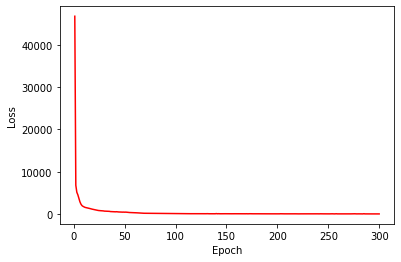

In [68]:
model_v_s_velocityPhy, t_loss, t_epochs = train(model_v_s_velocityPhy, train_dataloader_v_s, optimizer_v_s_velocityPhy, criterion, epochs)
loss_plot(t_epochs, t_loss)

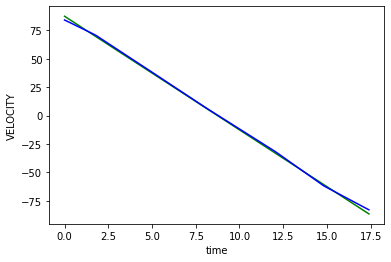

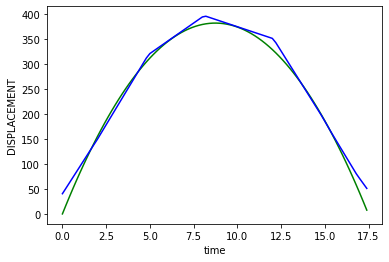

In [69]:
# Run simulation and compare
U_INITIAL = 87.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s_velocityPhy, U_INITIAL)
times, velocities, displacements        = simulate_flight(U_INITIAL)
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

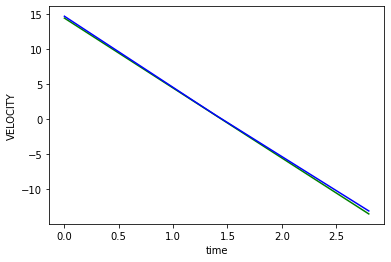

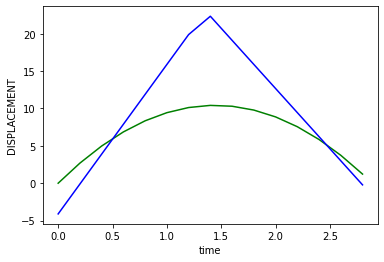

In [70]:
# Run simulation and compare, a case when u0 is small
U_INITIAL = 14.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s_velocityPhy, U_INITIAL)
times, velocities, displacements        = simulate_flight(U_INITIAL)
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

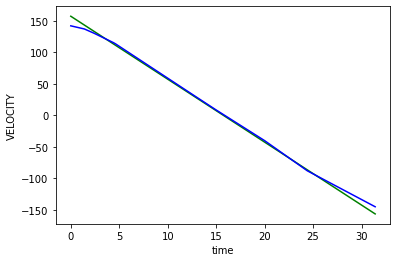

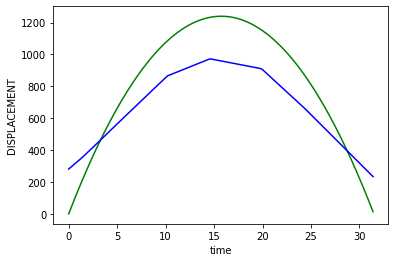

In [71]:
# Run simulation and compare, case where u0 is not part of train set
U_INITIAL = 157.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s_velocityPhy, U_INITIAL)
times, velocities, displacements        = simulate_flight(U_INITIAL)
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

The above experiment clearly shows that even without direct supervision on $s_t$, we have obtained equivalent results compared to direct supervision.

##### 2. Supervised + Physics based loss

Let us try out including both supervision and physics to guide our learning. We will use the following loss function.

$L_{supervised+phy} = (v_{predicted}-v_{actual})^2+(s_{predicted}-s_{actual})^2+\gamma*(v_{predicted}^2-u_{initial}^2-2*g*s_{predicted})^2$

$\gamma$ is used to control weightage given to the physics term.

In [56]:
class SupervisedPlusPhysicsBasedLoss(nn.Module):
  def __init__(self, gamma):
    super(SupervisedPlusPhysicsBasedLoss, self).__init__()
    self.gamma = gamma

  def forward(self, Y_predicted, Y_actual, X):
    v_predicted = Y_predicted[:, :, 0]
    s_predicted = Y_predicted[:, :, 1]
    u_initial = X[:, :, 0]
    v_square_from_s = torch.add(torch.square(u_initial), 2*g*s_predicted)
    v_square_from_predicted = torch.square(v_predicted)
    difference = torch.subtract(v_square_from_predicted, v_square_from_s)
    squared_difference = torch.square(difference)

    # supervised v term
    v_actual = Y_actual[:, :, 0]
    difference_v = torch.subtract(v_predicted, v_actual)
    squared_difference_v = torch.square(difference_v)

    # supervised s term
    s_actual = Y_actual[:, :, 1]
    difference_s = torch.subtract(s_predicted, s_actual)
    squared_difference_s = torch.square(difference_s)

    sqr_diff_sum = torch.add(squared_difference_v, squared_difference_s)
    sqr_diff_sum = torch.add(sqr_diff_sum, self.gamma*squared_difference)

    loss = torch.sum(sqr_diff_sum)
    loss = loss/X.shape[0]
    return loss

In [57]:
# We will be using the same datset as for velocity_displacement task.
BATCH_SIZE                  = 32
model_v_s_supervisedPhy     = PhysicsNewtonNet()
train_dataloader_v_s        = DataLoader(train_dataset_v_s_10000, batch_size=BATCH_SIZE, shuffle=True)
# optimizer_v_s_velocityPhy   = optim.SGD(model_v_s_velocityPhy.parameters(), lr=0.0001, momentum=0.9)
optimizer_v_s_supervisedPhy = optim.Adam(model_v_s_supervisedPhy.parameters(), lr = 0.005)
criterion                   = SupervisedPlusPhysicsBasedLoss(gamma=0.001)
epochs                      = 300

epoch : 0, loss : 13526.27496
epoch : 10, loss : 1208.31689
epoch : 20, loss : 764.86230
epoch : 30, loss : 704.08001
epoch : 40, loss : 685.12408
epoch : 50, loss : 665.41245
epoch : 60, loss : 657.29450
epoch : 70, loss : 669.01104
epoch : 80, loss : 640.74355
epoch : 90, loss : 650.72521
epoch : 100, loss : 550.10301
epoch : 110, loss : 394.08387
epoch : 120, loss : 339.72817
epoch : 130, loss : 281.95309
epoch : 140, loss : 260.16741
epoch : 150, loss : 247.86872
epoch : 160, loss : 234.68115
epoch : 170, loss : 218.47756
epoch : 180, loss : 205.08454
epoch : 190, loss : 205.82687
epoch : 200, loss : 185.10920
epoch : 210, loss : 186.73509
epoch : 220, loss : 162.09637
epoch : 230, loss : 150.42273
epoch : 240, loss : 138.67607
epoch : 250, loss : 137.67819
epoch : 260, loss : 131.77143
epoch : 270, loss : 121.77422
epoch : 280, loss : 132.17349
epoch : 290, loss : 113.14604
Done Training!
epoch : 300, loss : 107.79077


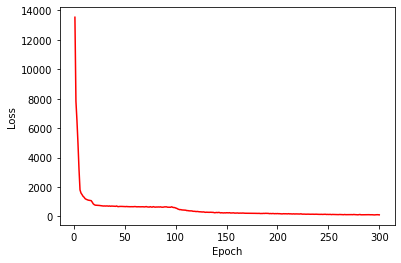

In [58]:
model_v_s_supervisedPhy, t_loss, t_epochs = train(model_v_s_supervisedPhy, train_dataloader_v_s, optimizer_v_s_supervisedPhy, criterion, epochs)
loss_plot(t_epochs, t_loss)

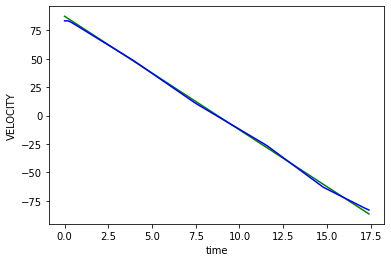

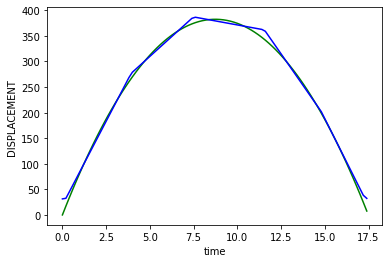

In [59]:
# Run simulation and compare
U_INITIAL = 87.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s_supervisedPhy, U_INITIAL)
times, velocities, displacements        = simulate_flight(U_INITIAL)
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

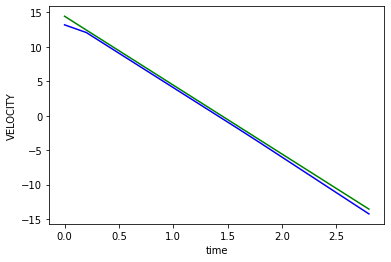

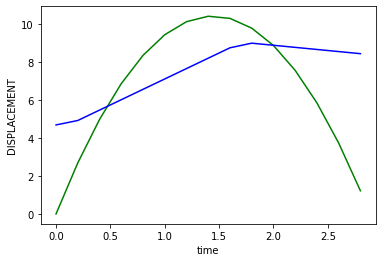

In [60]:
# Run simulation and compare, a case when u0 is small
U_INITIAL = 14.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s_supervisedPhy, U_INITIAL)
times, velocities, displacements        = simulate_flight(U_INITIAL)
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

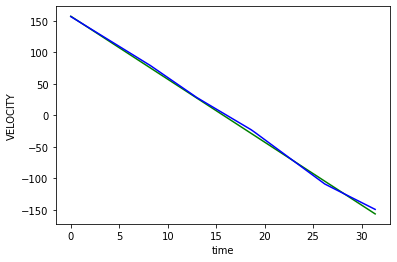

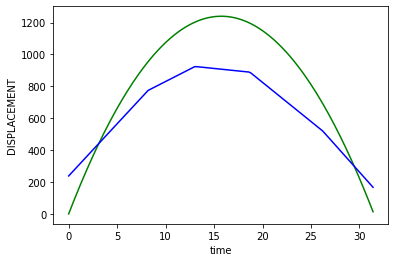

In [61]:
# Run simulation and compare, case where u0 is not part of train set
U_INITIAL = 157.4356
times_p, velocities_p, displacements_p  = simulation_inference('VELOCITY_DISPLACEMENT', model_v_s_supervisedPhy, U_INITIAL)
times, velocities, displacements        = simulate_flight(U_INITIAL)
compare_plot(times, velocities, velocities_p, 'VELOCITY')
compare_plot(times, displacements, displacements_p, 'DISPLACEMENT')

Looks like physics guide is helping us. The plots look a bit smoother than the ones without using physics term. 

## Summary

### Data Rich and Physics Certain
<style>
    .foo thead tr th:first-child,
    .foo tbody tr td:first-child {
    width: 5%;
    min-width: 1%;
    max-width: 5%;
    word-break: break-all;
    }
    .foo {
        font-size: 8pt;
    }
</style>
<div class="foo">

| Experiment 					| Parameters  											| Results  								| Comments 							|
| :---       					|    :----:   											|     :---: 							|     ---: 							|
| **DL + Data**																																						|
| Predicting only velocity  	| Dataset size : 10000<br> Network : 2->5->5->1 <br> activation: ReLU	|  ~100% accurate	| Generalises well over various initial velocities |
| Predicting only displacement 	| Dataset size : 10000<br> Network : 2->16->16->1 <br>	activation: ReLU |	Reasonable		| Better prediction for $u_0 \in dataset$, average prediction outside | 
| Predicting both $v_t, s_t$	| Dataset size : 10000<br> Network : 2->16->16->2 <br>	activation: tanh	|	Reasonable		| Better prediction for $u_0 \in dataset$, poor prediction outside |
| Predicting both $v_t, s_t$	| Dataset size : 10000<br> Network : 2->16->16->2 <br>	activation: ReLU	|	Reasonable		| Better prediction for $u_0 \in dataset$, average prediction outside |
| **DL + Physics**																																			|
| Predicting both $v_t, s_t$<br> using Loss<br> $L_{physics} = \|v_{predicted}^2-u_{initial}^2-2*g*s_{predicted}\|$ | Dataset size : 10000<br> Network : 2->16->16->1 <br>	activation: ReLU |	~0% accuracy		| Expected result as no supervision of any kind is provided |
| Predicting both $v_t, s_t$<br> using Loss<br>  $L_{velocity+phy} = (v_{predicted}-v_{actual})^2+\gamma*(v_{predicted}^2-u_{initial}^2-2*g*s_{predicted})^2$ | Dataset size : 10000<br> Network : 2->16->16->1 <br>	activation: ReLU |	Reasonable	| Prediction of $v_t$ is good. Was able to learn $s_t$ reasonably well without direct supervision |
| Predicting both $v_t, s_t$<br> using Loss<br>  $L_{supervised+phy} = (v_{predicted}-v_{actual})^2+(s_{predicted}-s_{actual})^2+\gamma*(v_{predicted}^2-u_{initial}^2-2*g*s_{predicted})^2$ | Dataset size : 10000<br> Network : 2->16->16->1 <br>	activation: ReLU |	Reasonable	| Not a better result w.r.t direct supervision |

</div>

**Observations :** 
- Physics equations are certain in this case and are the best to use.
- Both DL, Hybrid(DL+Physics) methods performance are equivalent (actual accuracy/loss varies based on fine training, random dataset generation)

Re running the above experiments with Dataset size of 200(Data Starvation), yielded the following observations
- DL performance is comparable with 10000 dataset when trained on much mode epochs(5x)
- Hybrid(DL+Physics) without direct supervision on $s_t$ has comparable/better closeness than DL only method for limited epochs($\sim$300) training.
